<center><h2>ALTeGraD 2022<br>Lab Session 2: Transfer learning for NLP</h2> 27 / 10 / 2022<br> M. Kamal Eddine, H. Abdine<br><br>


<b>Student name:</b> Waël Doulazmi

</center>

<br><br>
In this lab we will:
* Implement and pretrain a language model with transformer architecture.
* Use the pretrained model (transfer learning) to perform a sentiment analysis task which consists of classifying some books reviews into positive and negative ones.
* Compare the performance of the pretrained model to a model trained from scratch.
 <br>
 
<b>The deadline for this lab is November 14, 2022 11:59 PM.</b> More details about the submission and the architecture for this lab can be found in the handout PDF.

In [1]:
import math

import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### The Model

In [2]:
class TransformerModel(nn.Module):
    def __init__(self, ntoken, nhead, nhid, nlayers, dropout=0.5):
        super(TransformerModel, self).__init__()
        '''
        ntokens: the size of vocabulary
        nhid: the hidden dimension of the model.
        We assume that embedding_dim = nhid
        nlayers: the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
        nhead: the number of heads in the multiheadattention models
        dropout: the dropout value
         '''
        self.model_type = "Transformer"
        self.encoder = nn.Embedding(num_embeddings=ntoken, embedding_dim=nhid) # fill me, nhid = the dim_embed
        self.pos_encoder = PositionalEncoding(nhid, dropout=dropout) #fill me, the PositionalEncoding class is implemented in the next cell
        encoder_layers = nn.TransformerEncoderLayer(d_model=nhid, nhead=nhead, dim_feedforward=nhid,
                                                   dropout=dropout) #fill me we assume nhid = d_model = dim_feedforward
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, nlayers) #fill me
        self.nhid = nhid
        self.init_weights()

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = (
            mask.float()
            .masked_fill(mask == 0, float("-inf"))
            .masked_fill(mask == 1, float(0.0))
        )
        return mask

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src, src_mask):
        src = self.encoder(src) * math.sqrt(self.nhid) 
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, src_mask)
        return output


class ClassificationHead(nn.Module):
    def __init__(self, nhid, nclasses):
        super(ClassificationHead, self).__init__()
        self.decoder = nn.Linear(nhid, nclasses)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src):
        output = self.decoder(src)
        return output
    
class Model(nn.Module):
    def __init__(self, ntoken, nhead, nhid, nlayers, nclasses, dropout=0.5):
        super(Model, self).__init__()
        self.base = TransformerModel(ntoken, nhead, nhid, nlayers, dropout)
        self.classifier = ClassificationHead(nhid, nclasses)

    def forward(self, src, src_mask):
        # base model
        x = self.base(src, src_mask)
        # classifier model
        output = self.classifier(x)
        return output

In [3]:
class PositionalEncoding(nn.Module):
    def __init__(self, nhid, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, nhid)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, nhid, 2).float() * (-math.log(10000.0) / nhid)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[: x.size(0), :]
        return self.dropout(x)

Let's verify if our model works, by applying one inference step

In [10]:
ntokens = 100 # the size of vocabulary
nhid = 200  # hidden dimension
nlayers = 4  # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 2  # the number of heads in the multiheadattention models
dropout = 0  # the dropout value


model = Model(ntokens, nhead, nhid, nlayers, ntokens, dropout).to(device)
dummy_input = torch.tensor([[2, 6, 2, 5, 43, 21]]).to(device)
src_mask = model.base.generate_square_subsequent_mask(1).to(device)
out = model.forward(dummy_input, src_mask)

print(out.shape) # is it the right shape?

# Here output is : for each token in the vocabulary (100 tokens),
# It's probability to come after each word (6 tokens)
# In the given sequence (2,6,2,5,43,21)
# so the output should be of dim 6 * 100 which is the case !

torch.Size([1, 6, 100])


## Vocabulary and Tokenization

In [15]:
path_vocab = "data/dict.txt"
token2ind = {"<sos>": 0, "<pad>": 1, "<eos>": 2, "<oov>": 3} # the 4 first indices are reserved to special tokens
with open(path_vocab, "r", encoding='utf-8') as f:
    for idx, line in enumerate(f):
        word = line.split()[0].strip()
        token2ind[word] =  4 + idx

ind2token = {token2ind[token]: token for token in token2ind.keys()}

print(ind2token[1111])

▁trop


### Data Loader


In [16]:
import numpy
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset


class Dataset(Dataset):
    def __init__(
        self,
        path_documents,
        path_labels=None,
        token2ind={},
        max_len=512,
        task="language_modeling",
    ):
        self.task = task
        self.max_len = max_len
        self.token2ind = token2ind
        self.documents = []
        self.labels = []
        with open(path_documents, "r", encoding='utf_8') as f1:
            for line in f1:
                self.documents.append(line.strip())
        if task == "classification":
            with open(path_labels, "r") as f1:
                for line in f1:
                    self.labels.append(int(line.strip()))
            assert len(self.labels) == len(self.documents)

    def __len__(self):
        return len(self.documents)

    def __getitem__(self, index):
        sequence = self.documents[index].split()
        if len(sequence) > self.max_len - 1:
            sequence = sequence[: self.max_len - 1]
        source_sequence = [0] + [token2ind[token] if token in token2ind.keys() else 3 for token in sequence]
        # If we didn't crop the sequence we also add the eos token
        if len(sequence) < self.max_len - 1:
            source_sequence.append(2)
        #fill me (constract the input sequence using token2ind, sequence and special tokens)
        if self.task == "language_modeling":
            target = source_sequence[1:]
            target.append(self.token2ind["<eos>"])
        elif self.task == "classification":
            target = [self.labels[index]]
        sample = {
            "source_sequence": torch.tensor(source_sequence),
            "target": torch.tensor(target),
        }
        return sample


def MyCollator(batch):
    source_sequences = pad_sequence(
        #we use padding to match the length of the sequences in the same batch
        [sample["source_sequence"] for sample in batch], padding_value=token2ind["<pad>"]
    )
    target = pad_sequence(
        [sample["target"] for sample in batch], padding_value=token2ind["<pad>"]
    )
    return source_sequences, target.reshape(-1)


def get_loader(
    path_documents,
    path_labels=None,
    token2ind={},
    max_len=512,
    batch_size=32,
    task="language_modeling",
):
    dataset = Dataset(
        path_documents,
        path_labels=path_labels,
        token2ind=token2ind,
        max_len=512,
        task=task,
    )
    data_loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=MyCollator,
        pin_memory=True,
        drop_last=True,
    )
    return data_loader

## The Training

In [17]:
def train(
    path_data_train,
    path_labels_train=None,
    path_data_valid=None,
    save_interval=-1,
    log_interval=5,
    task="language_modeling",
    batch_size=32,
):
    model.train()
    total_loss = 0.0
    ntokens = len(token2ind)
    data_loader = get_loader(
        path_data_train,
        path_labels_train,
        token2ind,
        task=task,
        batch_size=batch_size,
    )
    
    losses = []
    for idx, data in enumerate(data_loader): #step 1
        optimizer.zero_grad()
        src_mask = model.base.generate_square_subsequent_mask(data[0].size(0)).to(
            device
        )
        input = data[0].to(device)
        output = model(input, src_mask) #step 2
        if task == 'classification':
            #last vector only
            output = output[-1,:,:]
        output = output.view(-1, output.shape[-1])
        target =  data[1]
        target = target.to(device)
        loss = criterion(output, target)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5) # prevent exploding gradient 
        #fill me step 4
        optimizer.step()

        total_loss += loss.item() 
        if idx % log_interval == 0 and idx > 0:
            cur_loss = total_loss / log_interval
            print(
                "| epoch {:3d} | {:5d}/{:5d} steps | "
                "loss {:5.5f} | ppl {:8.3f}".format(
                    epoch, idx, len(data_loader), cur_loss, math.exp(cur_loss),
                )
            )
            losses.append(cur_loss)
            total_loss = 0
    return losses

In [24]:
ntokens = len(ind2token) # the size of vocabulary
nhid = 200  # the dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 4  # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 2  # the number of heads in the multiheadattention models
dropout = 0  # the dropout value

nclasses = 2 # for classification task only

model = Model(ntokens, nhead, nhid, nlayers, ntokens, dropout).to(device)

In [25]:
print(ntokens)

50001


In [19]:
# optimization paramerters

criterion = nn.CrossEntropyLoss(ignore_index=token2ind['<pad>'])
lr = 0.0003  # learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [20]:
#!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/pretraining_subset.txt
path_data_train = "data/pretraining_subset.txt"

In [11]:
#pretraining on a tiny subset
log_interval = 500
epochs = 2
for epoch in range(1, epochs + 1): #5
    train(
        path_data_train,
        save_interval=-1,
        task="language_modeling", # fill me
        batch_size=16,
        log_interval=log_interval,
    )

| epoch   1 |   500/ 3125 steps | loss 7.08424 | ppl 1193.015
| epoch   1 |  1000/ 3125 steps | loss 6.25863 | ppl  522.505
| epoch   1 |  1500/ 3125 steps | loss 5.99199 | ppl  400.212
| epoch   1 |  2000/ 3125 steps | loss 5.85258 | ppl  348.131
| epoch   1 |  2500/ 3125 steps | loss 5.71147 | ppl  302.315
| epoch   1 |  3000/ 3125 steps | loss 5.63465 | ppl  279.962
| epoch   2 |   500/ 3125 steps | loss 5.33706 | ppl  207.900
| epoch   2 |  1000/ 3125 steps | loss 5.28275 | ppl  196.912
| epoch   2 |  1500/ 3125 steps | loss 5.27460 | ppl  195.312
| epoch   2 |  2000/ 3125 steps | loss 5.22453 | ppl  185.773
| epoch   2 |  2500/ 3125 steps | loss 5.20574 | ppl  182.316
| epoch   2 |  3000/ 3125 steps | loss 5.17918 | ppl  177.538


## Text Generation


In [12]:
#!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/pretrained_model_4layers.pt

model = Model(ntokens, nhead, nhid, nlayers, ntokens).to(device) 

#load the checkpoint
checkpoint = torch.load('pretrained_model_4layers.pt') 
#load state dict
model.load_state_dict(checkpoint['model_state_dict']) 

<All keys matched successfully>

In [13]:
#!pip install sentencepiece
#!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/sentencepiece.french.model

import sentencepiece as spm

s = spm.SentencePieceProcessor(model_file='sentencepiece.french.model') #load sentencepiece model

#examples
encoded = s.encode_as_pieces("Bonjour les amis!")
decoded = s.decode_pieces(encoded)
print(encoded)
print(decoded)

['▁Bonjour', '▁les', '▁amis', '!']
Bonjour les amis!


In [14]:
def infer_next_token(sent):
    model.eval()
    sent_pieces = s.encode_as_pieces(sent)
    source = [token2ind['<sos>']] + [token2ind[el] for el in sent_pieces] # list of tokens
    source = torch.tensor(source).to(device)
    source = source.reshape(-1, 1)
    src_mask = model.base.generate_square_subsequent_mask(source.size(0)).to(device)
    out = model(source, src_mask)
    next_token_ind =  int(torch.argmax(out[-1,0,:])) # most prob token after the last token
    return next_token_ind, out
    
def infer_next_tokens(sent, max_len=50):
    not_over = True
    length = len(sent)
    while length < max_len and not_over:
        token_ind = infer_next_token(sent)[0]
        not_over = token_ind !=2
        if not_over:
            sent += ' ' + s.decode_pieces(ind2token[token_ind])
            length+=1
            print(sent)

In [15]:
sent = "Bonjour les"
infer_next_tokens(sent)

Bonjour les gens
Bonjour les gens qui
Bonjour les gens qui ont
Bonjour les gens qui ont été
Bonjour les gens qui ont été très
Bonjour les gens qui ont été très accueillants
Bonjour les gens qui ont été très accueillants et
Bonjour les gens qui ont été très accueillants et sympathiques
Bonjour les gens qui ont été très accueillants et sympathiques .


### Supervised task

In [16]:
# !wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/train.review.spm
# !wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/train.label
# !wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/test.review.spm
# !wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/test.label

path_data_train = "data/train.review.spm"
path_labels_train = "data/train.label"

path_data_valid = "data/test.review.spm"
path_labels_valid = "data/test.label"

In [17]:
# a function to evaluate the validation accuracy of the model.
def evaluate_accuracy(data_loader, verbose=True):
    model.eval()
    ncorrect = ntotal = 0
    with torch.no_grad():
        for idx, data in enumerate(data_loader):
            # inference 
            source = data[0].to(device)
            src_mask = model.base.generate_square_subsequent_mask(source.size(0)).to(device)
            output = model(source, src_mask)
            output = nn.functional.softmax(output[-1,:,:], dim=-1)
            # total number of examples
            ntotal +=  output.shape[0]
            # number of correct predictions 
            predictions = torch.round(output[:, 1])
            #print("predictions", predictions)
            label = data[1].to(device)
            #print("labels", label)
            ncorrect += torch.sum(predictions==label) #fill me # number of correct prediction - hint: use torch.sum 
        acc = ncorrect.item() / ntotal
        if verbose:
          print("validation accuracy: {:3.2f}".format(acc*100))
        return acc

In [18]:
#save the base model to be loaded later in the fine-tuning phase
torch.save({"model_state_dict": model.base.state_dict(),}, "pretrained_model_4layers_no_class_head.pt")

In [19]:
from_scratch_settings = [True, False]

from_scratch_valid_acc = []
pretrained_valid_acc = []
lr = 0.0001

for from_scratch in from_scratch_settings:
    model = Model(ntokens, nhead, nhid, nlayers, 2, dropout).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    if not from_scratch:
        print("=====PRETRAINED MODEL======")
        #load checkpoint
        checkpoint = torch.load("pretrained_model_4layers_no_class_head.pt")
        #load state dict
        model.base.load_state_dict(checkpoint['model_state_dict'])
    else:
        print("=====Trainig FROM SCRATCH======")
    epochs = 15
    for epoch in range(1, epochs + 1):
        train(
            path_data_train,
            path_labels_train,
            save_interval=-1,
            task='classification',
            batch_size=8,
            log_interval=50,
        )
        acc = evaluate_accuracy(
            get_loader(
                path_data_valid,
                path_labels_valid,
                token2ind=token2ind,
                batch_size=20,
                task='classification',
            )
        )
        if from_scratch:
            from_scratch_valid_acc.append(acc)
        else:
            pretrained_valid_acc.append(acc)
    print()

=====Trainig FROM SCRATCH======
| epoch   1 |    50/  200 steps | loss 0.82276 | ppl    2.277
| epoch   1 |   100/  200 steps | loss 0.72513 | ppl    2.065
| epoch   1 |   150/  200 steps | loss 0.75930 | ppl    2.137
validation accuracy: 58.30
| epoch   2 |    50/  200 steps | loss 0.62912 | ppl    1.876
| epoch   2 |   100/  200 steps | loss 0.67138 | ppl    1.957
| epoch   2 |   150/  200 steps | loss 0.65583 | ppl    1.927
validation accuracy: 65.70
| epoch   3 |    50/  200 steps | loss 0.46150 | ppl    1.586
| epoch   3 |   100/  200 steps | loss 0.45437 | ppl    1.575
| epoch   3 |   150/  200 steps | loss 0.39543 | ppl    1.485
validation accuracy: 63.50
| epoch   4 |    50/  200 steps | loss 0.17086 | ppl    1.186
| epoch   4 |   100/  200 steps | loss 0.15355 | ppl    1.166
| epoch   4 |   150/  200 steps | loss 0.28639 | ppl    1.332
validation accuracy: 74.80
| epoch   5 |    50/  200 steps | loss 0.03364 | ppl    1.034
| epoch   5 |   100/  200 steps | loss 0.02968 | ppl  

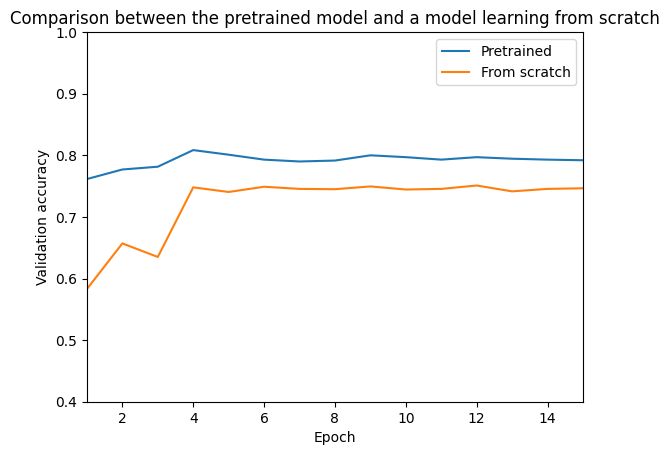

In [23]:
import numpy as np
import matplotlib.pyplot as plt

scratch = np.array(from_scratch_valid_acc)
pretrained = np.array(pretrained_valid_acc)
epochs = np.arange(1,16)

plt.ylabel('Validation accuracy')
plt.xlabel('Epoch')

plt.ylim(0.4,1)
plt.xlim(1,15)

plt.plot(epochs, pretrained, label='Pretrained')
plt.plot(epochs, scratch, label= 'From scratch')

plt.title("Comparison between the pretrained model and a model learning from scratch")


plt.legend()
plt.show()